# Maskovid-19 project

>Nicola Vanoli & Guido Farinacci

>Brescia (Italy), June 2020

In this project we propose a machine learning based model with the aim of extracting human faces from input images and detecting if the depicted people wear face masks: the aim is to provide a useful tool for the management of admissions into public places where wearing a face mask is mandatory, which has now become common because of the Covid-19 outbreak.

The project is divided in five parts: 
* first we train a 2 classes DCNN that receives input images of faces and detects the presence of a face-mask (section **Training**);
* in the second section (**Model choice**) we offer the possiblity to load weights for the same model trained by us locally on a more complete dataset;
* then we use a pre-trained CNN, called MTCNN (multi-task cascaded convolutional neural network), which is able to detect human faces in input images and returns the coordinates of the faces as output (section **MTCNN face detector**);
* in the following section (**Testing**) the overall model, which consists of the MTCNN face detector and our Maskovid-19 classifier, is tested on provided sample images. The output is given by drawing boxes of different colours around the faces depicted in the image according to the presence of a face mask;
* lastly (section **Custom image testing**) we let the reader choose a sample image and run it through the network to generate predictions.


In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2


# TRAINING MODULES

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

# TESTING MODULES 

from google.colab.patches import cv2_imshow
from google.colab import files
from tensorflow.keras.models import load_model
from matplotlib.patches import Rectangle
from tensorflow.keras.preprocessing.image import img_to_array


print(f"Numpy version: {np.__version__}")
print(f"Tensorflow version: {tf.__version__}")

Numpy version: 1.18.5
Tensorflow version: 2.2.0


## Training

In this section we will build a deep convolutional neural network with the task of classifying images of human faces in two classes, face-mask users and non-users.\
Our model will be trained on a dataset kindly offered by "X-zhangyang",  freely available online at:
https://github.com/X-zhangyang/Real-World-Masked-Face-Dataset .

Since the full dataset is incovenient to load at once in Colab, we will use a smaller part of it on this notebook, although a pre-trained model trained locally by us on more data can be used for testing purposes (further explanation in the following sections).




We begin by checking whether a GPU is available for the Colab runtime.

In [2]:
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  print('GPU device not found, you should consider enabling it for this experiment!')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Data preparation

The training dataset for the notebook is available online; the first thing to do is to make it available in our Colab session by downloading it.

The raw dataset consists of 95000 images, although only 5000 of them depict people wearing face masks: training our model on such an unbalanced dataset would negatively affect the prediction accuracy. Therefore, we have selected a smaller portion of the dataset so that we have 50%-50% balance between the two classes. In particular, we have created two different sub-datasets:
- a smaller 800 + 800 to be used in the Colab session, where the dataset must be downloaded every time the runtime is connected;
- a larger 5000 + 5000 dataset to be used when training locally.

Note that the dataset consists of 2 `.npy` arrays, each containing 800 224x224 colour images of faces.

In [3]:
# LOADING DATASET
!wget -O with_mask.zip https://www.dropbox.com/s/othhl5h3hbmncge/800_faces_with_mask_%28224%2C%20224%2C%203%29_clean.zip?dl=0
!wget -O without_mask.zip https://www.dropbox.com/s/ywtjdl96hxf65xm/800_faces_without_mask_%28224%2C%20224%2C%203%29_clean.zip?dl=0
# UNZIPPING DATASET
!unzip with_mask.zip
!unzip without_mask.zip

# DELETING .ZIP FILES
!rm with_mask.zip
!rm without_mask.zip

--2020-06-11 15:14:19--  https://www.dropbox.com/s/othhl5h3hbmncge/800_faces_with_mask_%28224%2C%20224%2C%203%29_clean.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/othhl5h3hbmncge/800_faces_with_mask_%28224%2C%20224%2C%203%29_clean.zip [following]
--2020-06-11 15:14:19--  https://www.dropbox.com/s/raw/othhl5h3hbmncge/800_faces_with_mask_%28224%2C%20224%2C%203%29_clean.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbe247ac04a172c0f87292d2b8e.dl.dropboxusercontent.com/cd/0/inline/A5cDOdNoRvVQrGgokenCpo__a93deCufj5QPf9uzxpNiemX2ropLG1O2XuRf7cgFxBCNgOYPaWLvuQNb1GDvdCDBLppQ9XrX0MRjhVLwB9Zko-0KRbEhgACROndjKo5USYA/file# [following]
--2020-06-11 15:14:19--  https://ucbe247ac04a172c0f87292d2b8e.dl.dropboxuserc

We unify the two mask and no-mask arrays into a single `numpy` array:

In [4]:
data_mask = np.load("800_faces_with_mask_(224, 224, 3)_clean.npy") 

data_nomask = np.load("800_faces_without_mask_(224, 224, 3)_clean.npy")

data = np.concatenate((data_mask, data_nomask), axis=0)
data = np.float32(data) # convert to float32

print("Image dataset shape:", data.shape)

Image dataset shape: (1600, 224, 224, 3)


To ensure maximum reproducibility we set seeds for both `numpy` and `tensorflow`.

In [0]:
np.random.seed(15)
tf.random.set_seed(12)

To have an idea of the data we are working with, we inspect three random images in the dataset:

Image index in dataset: 1480, NO MASK


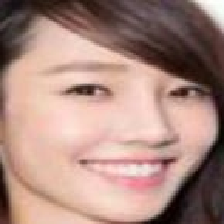


Image index in dataset: 645, MASK


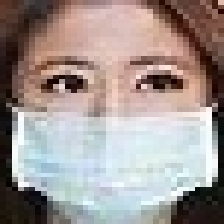


Image index in dataset: 384, MASK


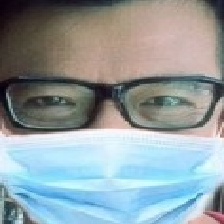

In [6]:
num_samples = 3

for i in range(num_samples):
    index = np.random.randint(0, 1599)
    if index < 800:
        lab = "MASK"
    else:
        lab = "NO MASK"
    print(f"Image index in dataset: {index}, {lab}")

    image = cv2.cvtColor(data[index], cv2.COLOR_BGR2RGB)
    cv2_imshow(image)

    print()

The _label array_ is built by assigning a 1 to images of masked faces and a 0 to non-masked faces, according to the way we concatenated the `data_mask` and `data_nomask` initial datasets.

In [7]:
label = np.concatenate((np.ones(data_mask.shape[0]), np.zeros(data_nomask.shape[0])), axis=0)

print("Label dataset shape:", label.shape)

Label dataset shape: (1600,)


The dataset is divided into training and validation with a proportion of 80%-20% and it is loaded into an object of class `tensorflow.Dataset`.

In [8]:
# we use a function from scikit.learn to split train and validation data.
# the data is automatically shuffled
(trainX, valX, trainY, valY) = train_test_split(data, label, test_size=0.20, random_state=42)

# a Tensorflow dataset is built from data:
train = tf.data.Dataset.from_tensor_slices((trainX, trainY))
val = tf.data.Dataset.from_tensor_slices((valX, valY))

input_shape = data.shape[1:]
shape_trainX = trainX.shape[0]
shape_valX = valX.shape[0]

print("Train dataset:", train)
print("Validation dataset:", val)
print()
print(f"The number of images in the train dataset is {shape_trainX}.")
print(f"The number of images in the validation dataset is {shape_valX}.")

Train dataset: <TensorSliceDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.float64)>
Validation dataset: <TensorSliceDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.float64)>

The number of images in the train dataset is 1280.
The number of images in the validation dataset is 320.


The dataset is then prepared for batching.

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train.repeat().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val.batch(BATCH_SIZE)

To check that our code is working properly we inspect a single batch:

In [10]:
for image_batch, label_batch in train_dataset.take(1):
   pass

print("Images batch shape: ", image_batch.shape)
print("Label batch shape: ", label_batch.shape)

Images batch shape:  (32, 224, 224, 3)
Label batch shape:  (32,)


### Model architecture

Using `tensorflow.keras`, we create a new deep convolutional neural network.

The model consists of 5 blocks, of which the first 4 combine an average pooling layer with two subsequent convolutional layers, while the last block ends with a single dense neuron which outputs the prediction logit. The architecture of this model has been partially inspired by the `VGG16` model which, instead of using large convulutional filters like many of its competitors, employs smaller filters distributed in two levels next to each other, reducing the number of overall trainable parameters.

![VGG16](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

*Architecture of the VGG16 model, taken from https://neurohive.io/en/popular-networks/vgg16/*.

\
Another feature of our model is a starting average pooling layer: even though this reduces the information coming from the input images, we have found experimentally that this does not particularly affect the final prediction accuracy and it greatly speeds up training time by reducing the number of model parameters.


In [0]:
model = Sequential()

model.add(Input(shape=input_shape))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (32,32), padding='same'))
model.add(Conv2D(32, (32,32), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (16,16), padding='same'))
model.add(Conv2D(64, (16,16), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (8,8), padding='same'))
model.add(Conv2D(128, (8,8), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Conv2D(256, (4,4), padding='same'))
model.add(Conv2D(256, (4,4), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(AveragePooling2D(pool_size=(7,7)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1))

Since there are two classes, we use a binary cross-entropy loss function; we have also chosen the `Adam` optimizer.\
A summary of the model can be found below:

In [12]:
learning_rate = 1e-06

optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d (AveragePo (None, 112, 112, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 32)      98336     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      1048608   
_________________________________________________________________
activation (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        5

We define a checkpoint to ensure that during the training proces only the weights that ensure minimum validation loss are kept.

In [0]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model.weights.best.hdf5', 
                                                  verbose=1, save_best_only=True)

### Model training

In [14]:
EPOCHS = 30

history = model.fit(train_dataset, epochs=EPOCHS, 
                    callbacks=checkpointer, 
                    steps_per_epoch=shape_trainX//BATCH_SIZE, 
                    validation_data=val_dataset)

Epoch 1/30
40/40 [==============================] - ETA: 0s - loss: 1.9936 - accuracy: 0.5672
Epoch 00001: val_loss improved from inf to 0.37944, saving model to model.weights.best.hdf5
40/40 [==============================] - 13s 330ms/step - loss: 1.9936 - accuracy: 0.5672 - val_loss: 0.3794 - val_accuracy: 0.7656
Epoch 2/30
40/40 [==============================] - ETA: 0s - loss: 0.6401 - accuracy: 0.7148
Epoch 00002: val_loss improved from 0.37944 to 0.29966, saving model to model.weights.best.hdf5
40/40 [==============================] - 13s 324ms/step - loss: 0.6401 - accuracy: 0.7148 - val_loss: 0.2997 - val_accuracy: 0.8562
Epoch 3/30
40/40 [==============================] - ETA: 0s - loss: 0.4517 - accuracy: 0.8047
Epoch 00003: val_loss improved from 0.29966 to 0.27861, saving model to model.weights.best.hdf5
40/40 [==============================] - 13s 325ms/step - loss: 0.4517 - accuracy: 0.8047 - val_loss: 0.2786 - val_accuracy: 0.8344
Epoch 4/30
40/40 [====================

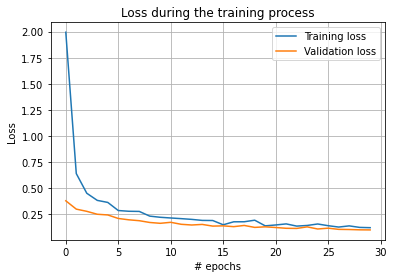

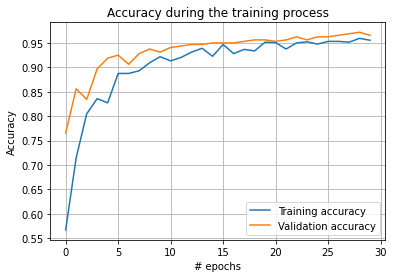

In [15]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("Loss during the training process")
plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title("Accuracy during the training process")
plt.xlabel('# epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

## Model choice

For practical reasons, the above model is trained on a small dataset (1600 images), for a small number of epochs.

We now report the results obtained from the same model trained locally on a larger dataset of 10000 images and higher number of epochs.




We trained the model for 300 epochs with a learning rate of $10^{-7}$; only the weights corresponding to the epoch with minimal validation loss were kept.

Naturally, comparing results from the two models is unwise, as they were trained on different data; in general, the locally trained model should offer greater accuracy in a testing environment as it has been trained on a much more complete dataset.

--2020-06-11 15:23:47--  https://www.dropbox.com/s/sak8jm0uzjv5sgt/accuracy.png?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/sak8jm0uzjv5sgt/accuracy.png [following]
--2020-06-11 15:23:47--  https://www.dropbox.com/s/raw/sak8jm0uzjv5sgt/accuracy.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4dfcda28cce479f82b8754ffd3.dl.dropboxusercontent.com/cd/0/inline/A5ce9MuDRspmJZ96_DVXr_h52XvYCGcitpOdXUkSLBgGBsRzt7Ou1kEDrYgIDFh9TrbHwhlagMKFEDv4_B4YI3x8ceiIPy-L-HqvNO6UbuXk2fP39JHzsdugcmN_Qnn58vo/file# [following]
--2020-06-11 15:23:48--  https://uc4dfcda28cce479f82b8754ffd3.dl.dropboxusercontent.com/cd/0/inline/A5ce9MuDRspmJZ96_DVXr_h52XvYCGcitpOdXUkSLBgGBsRzt7Ou1kEDrYgIDFh9TrbHwhlagMKFEDv4_B4YI3x8ceiIPy-L-HqvNO6Ubu

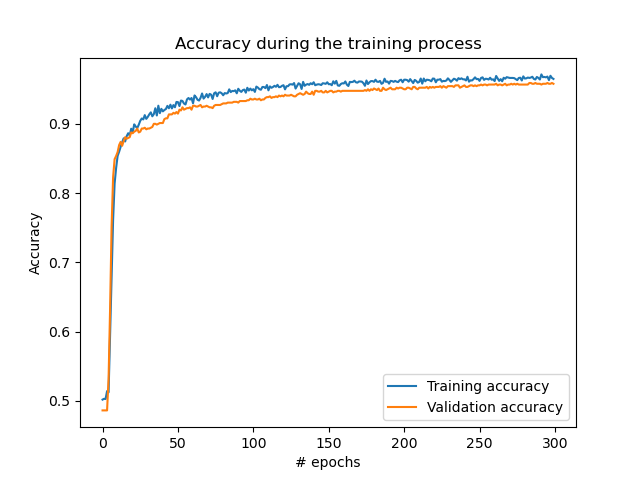

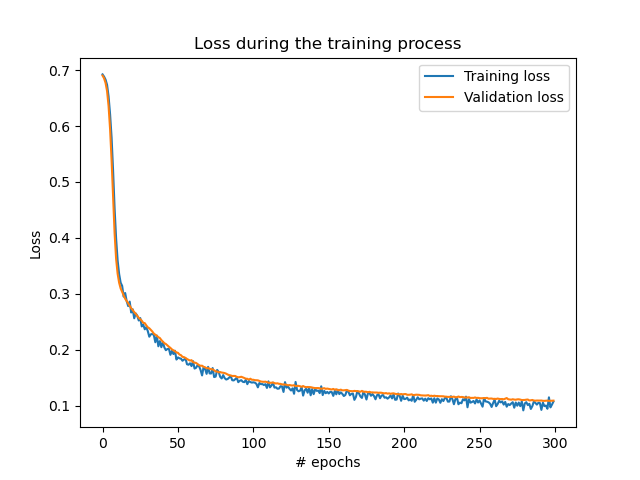

In [16]:
!wget -O accuracy.png https://www.dropbox.com/s/sak8jm0uzjv5sgt/accuracy.png?dl=0
!wget -O loss.png https://www.dropbox.com/s/ceolly8am4jxefj/loss.png?dl=0
!wget -O pretrained_model.hdf5 https://www.dropbox.com/s/c375oht2fqtdyn3/MODEL.CLEAN_V3.model.weights.hdf5?dl=0

cv2_imshow(cv2.imread("accuracy.png"))

cv2_imshow(cv2.imread("loss.png"))

In the following code box, the user can choose the weights for the Maskovid-19 neural network; by default the model is loaded with the locally trained weights.\
The user can also choose to employ the weights trained on this Colab notebook by changing the first variable to `True`.

In [0]:
# set this flag to False to use weights trained on the larger dataset
colab_model = False

if colab_model:
  model_path = "model.weights.best.hdf5"  
else:
  model_path = "pretrained_model.hdf5"

model = load_model(model_path)

## MTCNN face detector

In this section we set-up the MTCNN face detector to detect human faces in input images and we create the function that feeds the faces into our Maskovid-19 network for classification.\
Further information on the MTCNN model can be found at: https://pypi.org/project/mtcnn/.

### Model loading

First, we need to install the `mtcnn` package.

In [18]:
!pip install mtcnn
from mtcnn.mtcnn import MTCNN

     |████████████████████████████████| 2.3MB 9.6MB/s 


Using TensorFlow backend.


We can now build the function that concatenates the MTCNN face detector with our classification model.

In [0]:
detector = MTCNN()

def mask_detect(img):
    """
    This function takes the path of an image as input.
    The image is run through the MTCNN face detector; the detected
    faces are then run through our neural network to detect the
    presence of a face mask and the result is given as an
    output image.
    """

    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    w, h, _ = image.shape
    if w < 224 and h < 224:
        print("Image resolution too low to be analyzed!")
        return

    # pass the image through the MTCNN and obtain the face detections
    faces = detector.detect_faces(image)
    
    face_counter = 0
    # loop over the detection

    if faces is None:
      print("------------------")
      print("No faces detected!")
      print("------------------")

      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      cv2_imshow(image)
      return

    for face in faces:

        # extract the confidence associated with the detection
        confidence = face["confidence"]
        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.9:
            face_counter +=1
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = face["box"]
            (startX, startY, width, height) = box
            
            # extract the face, resize it to 224x224
            face = image[max(0,startY):startY+height, max(0,startX):startX+width]
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = np.expand_dims(face, axis=0)

            # pass the face through the model to determine if the face
            # has a mask or not
            logit = model.predict(face)
            mask_prob = tf.keras.activations.sigmoid(logit)

            # determine the class label and color we'll use to draw
            # the bounding box and text
            label = "Mask" if mask_prob > 0.5 else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (255, 0, 0)

            # display the label and bounding box rectangle on the output frame
            cv2.putText(image, label, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color)
            cv2.rectangle(image, (startX, startY), (startX+width, startY+height), color, 2)

    if face_counter == 0:
      print("------------------")
      print("No faces detected!")
      print("------------------")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2_imshow(image)

## Testing

In this section we will test the overall model on new images.


To test the model, we begin by downloading a folder of test images.

In [20]:
!wget -O examples.zip https://www.dropbox.com/s/umw07ov0wqbhq96/test_images.zip?dl=0
!unzip -d examples examples.zip
!rm examples.zip

--2020-06-11 15:25:28--  https://www.dropbox.com/s/umw07ov0wqbhq96/test_images.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/umw07ov0wqbhq96/test_images.zip [following]
--2020-06-11 15:25:28--  https://www.dropbox.com/s/raw/umw07ov0wqbhq96/test_images.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9393f37c49489ac06adcc670d9.dl.dropboxusercontent.com/cd/0/inline/A5eLBIbXCHsyvP1nX9LKciryvSaA6dw1znQJ6P4XRl9nwY6IysrX4LWbEV-C1iBrtfhmjUG5NrnkZ3KF6Llmhkh2ZSxAmAzdbctJQTkG1c1OnSzzZs38L4NJmVVRAh2qJsQ/file# [following]
--2020-06-11 15:25:29--  https://uc9393f37c49489ac06adcc670d9.dl.dropboxusercontent.com/cd/0/inline/A5eLBIbXCHsyvP1nX9LKciryvSaA6dw1znQJ6P4XRl9nwY6IysrX4LWbEV-C1iBrtfhmjUG5NrnkZ3KF6Llmhkh2ZSxAmAzdb

We then apply our pipeline to each of the test images:

In [21]:
for img in os.listdir("./examples/"):
    image = "./examples/" + img
    print("Analyzed image:")
    print(image)
    mask_detect(image)
    print()

Output hidden; open in https://colab.research.google.com to view.

## Custom image testing
Upload an image by running the following code cell and test our DCNN:

In [0]:
uploaded = files.upload()
for fn in uploaded.keys():
  mask_detect(fn)